<a href="https://colab.research.google.com/github/mahima8178/100-pandas-puzzles/blob/master/Vgg16%20on%20spect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import warnings
import pathlib
import random
import numpy as np
from urllib.request import urlopen
from zipfile import ZipFile

# Dependency imports
from absl import flags

import matplotlib
matplotlib.use("Agg")
%matplotlib notebook
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# For TF2, eager execution will break some code, so disable for now.
tf.compat.v1.disable_eager_execution()
warnings.simplefilter(action="ignore")

try:
  import seaborn as sns  # pylint: disable=g-import-not-at-top
  HAS_SEABORN = True
except ImportError:
  HAS_SEABORN = False

tfd = tfp.distributions

zipurl = 'https://github.com/mtwenzel/parkinson-classification/raw/master/data/PPMI-classification.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [2]:
#@title Imports. {display-mode:'form'}
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import glob
import os
import numpy
import seaborn as sns
from itertools import chain
from pathlib import Path

In [4]:

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"

In [5]:
%cd /content/drive/My Drive/Kaggle/

/content/drive/My Drive/Kaggle


In [6]:
metadata = pd.read_csv('data-ppmi/PPMI.csv')

In [7]:
metadata.head(10)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,388628,4140,Control,M,76,0,SPECT,Reconstructed DaTSCAN,Processed,4/09/2013,DCM,5/27/2018
1,388627,4139,Control,M,81,0,SPECT,Reconstructed DaTSCAN,Processed,3/19/2013,DCM,5/27/2018
2,388626,4137,PD,M,70,0,SPECT,Reconstructed DaTSCAN,Processed,4/02/2013,DCM,5/27/2018
3,388625,4136,PD,M,56,0,SPECT,Reconstructed DaTSCAN,Processed,2/13/2013,DCM,5/27/2018
4,451290,4135,PD,M,68,5,SPECT,Reconstructed DaTSCAN,Processed,2/18/2014,DCM,5/27/2018
5,388624,4135,PD,M,67,0,SPECT,Reconstructed DaTSCAN,Processed,2/06/2013,DCM,5/27/2018
6,504501,4135,PD,M,69,7,SPECT,Reconstructed DaTSCAN,Processed,3/12/2015,DCM,5/27/2018
7,913220,4126,PD,M,60,11,SPECT,Reconstructed DaTSCAN,Processed,4/06/2017,DCM,5/27/2018
8,388622,4126,PD,M,56,0,SPECT,Reconstructed DaTSCAN,Processed,3/07/2013,DCM,5/27/2018
9,504482,4126,PD,M,58,7,SPECT,Reconstructed DaTSCAN,Processed,4/15/2015,DCM,5/27/2018


In [8]:
metadata.head(-20)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,388628,4140,Control,M,76,0,SPECT,Reconstructed DaTSCAN,Processed,4/09/2013,DCM,5/27/2018
1,388627,4139,Control,M,81,0,SPECT,Reconstructed DaTSCAN,Processed,3/19/2013,DCM,5/27/2018
2,388626,4137,PD,M,70,0,SPECT,Reconstructed DaTSCAN,Processed,4/02/2013,DCM,5/27/2018
3,388625,4136,PD,M,56,0,SPECT,Reconstructed DaTSCAN,Processed,2/13/2013,DCM,5/27/2018
4,451290,4135,PD,M,68,5,SPECT,Reconstructed DaTSCAN,Processed,2/18/2014,DCM,5/27/2018
...,...,...,...,...,...,...,...,...,...,...,...,...
1544,418465,3012,PD,M,60,5,SPECT,Reconstructed DaTSCAN,Processed,1/11/2013,DCM,5/27/2018
1545,419655,3012,PD,M,61,7,SPECT,Reconstructed DaTSCAN,Processed,1/08/2014,DCM,5/27/2018
1546,341199,3012,PD,M,59,0,SPECT,Reconstructed DaTSCAN,Processed,10/11/2011,DCM,5/27/2018
1547,341198,3011,Control,M,32,0,SPECT,Reconstructed DaTSCAN,Processed,7/07/2011,DCM,5/27/2018


In [9]:
PATH = ""
SPECTPATH = Path("data-ppmi/")

In [10]:
lstFilesDCM = []
for file in glob.glob(f'{SPECTPATH}PPMI*/**/Reconstructed_DaTSCAN/**/**/*.dcm'):
    lstFilesDCM.append(file)

In [11]:
len(lstFilesDCM)

0

In [12]:
df = metadata[['Image Data ID','Group','Subject','Age','Sex']].set_index('Image Data ID')
for index, rows in df.iterrows():
    for i in lstFilesDCM:
        j = i.split("_")[13].strip()
        j = int(j[1:7])
        if index == j:
          df.loc[df.index == j, "Filenames"] 

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
print('Notebook run using keras:', keras.__version__)


import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.io import imread

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import math
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from scipy import misc
from random import shuffle
from collections import Counter
from numpy import expand_dims

import tensorflow as tf


init_notebook_mode(connected=True)
RANDOM_SEED = 123
IMG_SIZE = (224,224)

Notebook run using keras: 2.4.3


In [14]:
vgg = VGG16(
    weights=None,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
# Changing the architecture for transfer learning

NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False),
              metrics=["accuracy"])

vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Function to load data

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [17]:
# Load images into set variables

X_train_crop, y_train, labels = load_data('data-ppmi/code and data/TRAIN_CROP/')
X_test_crop, y_test, _ = load_data('data-ppmi/code and data/TEST_CROP/')
X_val_crop, y_val, _ = load_data('data-ppmi/code and data/VAL_CROP/')

  0%|          | 0/2 [00:00<?, ?it/s]

516 images loaded from data-ppmi/code and data/TRAIN_CROP/ directory.
65 images loaded from data-ppmi/code and data/TEST_CROP/ directory.


100%|██████████| 2/2 [00:00<00:00, 14.94it/s]

64 images loaded from data-ppmi/code and data/VAL_CROP/ directory.


In [18]:
#resize images to fit input layer of CNN ie 224x224

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [19]:
# Load resized images into final set variables

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [20]:
from IPython.display import clear_output
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.inception_v3 import InceptionV3

In [21]:

#more imports

import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123


In [22]:
#function to load data

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [24]:
"""
directory structure

├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

"""

TRAIN_DIR = 'data-ppmi/code and data/TRAIN_CROP/'
TEST_DIR = 'data-ppmi/code and data/TEST_CROP/'
VAL_DIR = 'data-ppmi/code and data/VAL_CROP/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|          | 0/2 [00:00<?, ?it/s]

516 images loaded from data-ppmi/code and data/TRAIN_CROP/ directory.
65 images loaded from data-ppmi/code and data/TEST_CROP/ directory.


100%|██████████| 2/2 [00:00<00:00, 14.93it/s]

64 images loaded from data-ppmi/code and data/VAL_CROP/ directory.


In [25]:
#code to plot grph below

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [26]:

def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

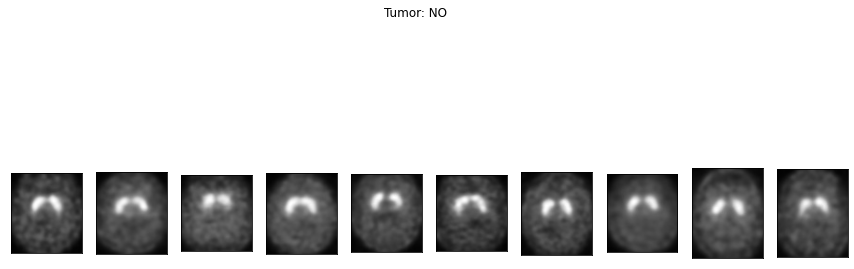

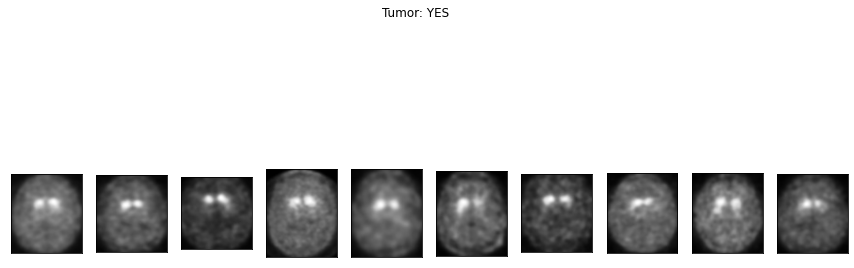

In [27]:
plot_samples(X_train, y_train, labels, 10)

In [28]:
#crop images to get rid of black spces round brain 

def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [29]:
#crop images to get rid of black spces round brain 

def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [30]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

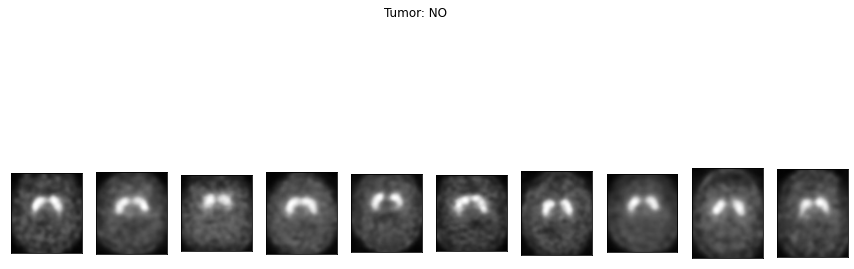

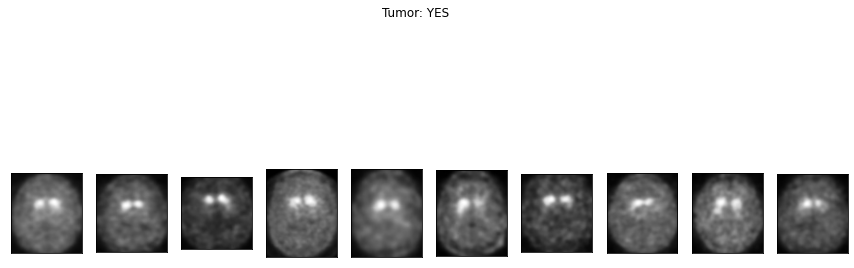

In [31]:
plot_samples(X_train_crop, y_train, labels, 10)

In [32]:

def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [33]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [34]:
#resize images to fit input layer of CNN ie 224x224

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [35]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

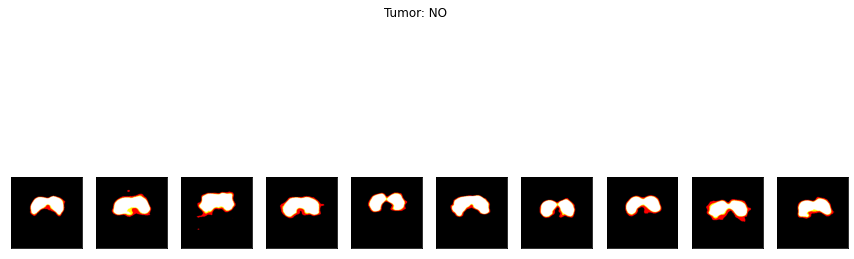

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

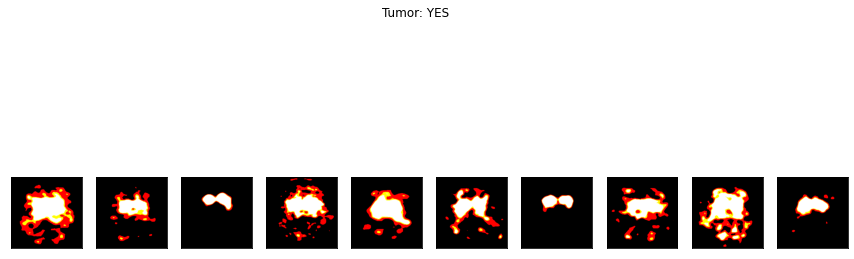

In [36]:
plot_samples(X_train_prep, y_train, labels, 10)

In [37]:
# Augmentation of images done because of small dataset and to prevent 
# overfitting. Google about augmentation in DL if needed.
#set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
)

In [38]:
#Just a preview of augmentations
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

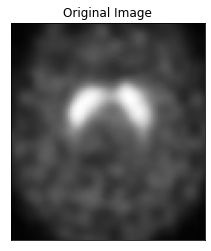

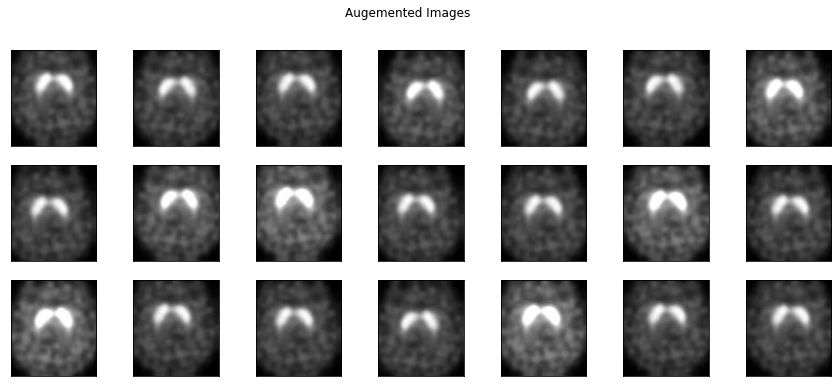

In [39]:

plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [40]:
# removing the preview folder, since not needed
!rm -rf preview/
print(IMG_SIZE)

(224, 224)


In [41]:
#SOME PROBLEM HERE ONLY

TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 516 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [45]:
vgg = VGG16(weights='imagenet',
    include_top=False, 
    input_shape=((224, 224,3))
)

58892288/58889256 [==============================] - 0s 0us/step


In [51]:
NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
vgg16.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
import time

start = time.time()

vgg16_history = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=120,
    verbose = 1,
    callbacks=None,
    validation_data=validation_generator,
    validation_steps=30,
    validation_freq=1,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)


end = time.time()
print(end - start)

Epoch 1/120
50/50 [==============================] - 31s 421ms/step - batch: 24.5000 - size: 30.3200 - loss: 1.5597 - accuracy: 0.6893 - val_loss: 0.5036 - val_accuracy: 0.7833
Epoch 2/120
50/50 [==============================] - 21s 423ms/step - batch: 24.5000 - size: 30.3200 - loss: 0.8077 - accuracy: 0.7955 - val_loss: 0.4422 - val_accuracy: 0.8750
Epoch 3/120
50/50 [==============================] - 20s 413ms/step - batch: 24.5000 - size: 30.3200 - loss: 0.6984 - accuracy: 0.8186 - val_loss: 0.4886 - val_accuracy: 0.8125
Epoch 4/120
50/50 [==============================] - 20s 416ms/step - batch: 24.5000 - size: 30.3200 - loss: 0.6488 - accuracy: 0.8252 - val_loss: 0.4365 - val_accuracy: 0.8417
Epoch 5/120
50/50 [==============================] - 20s 405ms/step - batch: 24.5000 - size: 30.3200 - loss: 0.5679 - accuracy: 0.8417 - val_loss: 0.4904 - val_accuracy: 0.8292
Epoch 6/120
50/50 [==============================] - 20s 409ms/step - batch: 24.5000 - size: 30.8800 - loss: 0.5134

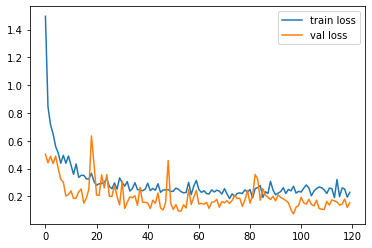

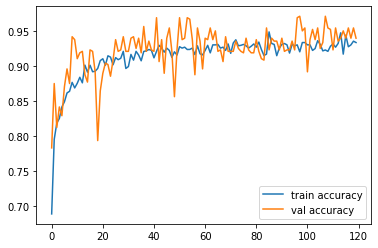

In [58]:
plt.plot(vgg16_history.history['loss'], label='train loss')
plt.plot(vgg16_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Depending on the version of TF/Keras, the metric is either stored as 'acc' or 'accuracy'. This is not checked here.
plt.plot(vgg16_history.history['accuracy'], label='train accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [59]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [60]:

# validate on val set
predictions = vgg16.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.97


In [61]:
# validate on test set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

print(predictions)

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Test Accuracy = 0.92


In [62]:
print(predictions)

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


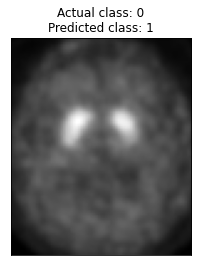

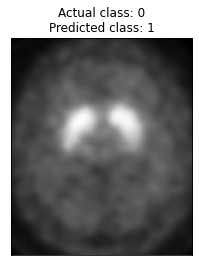

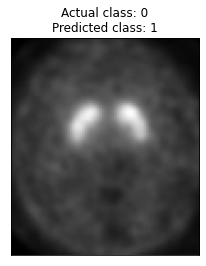

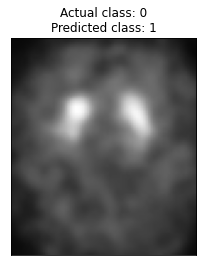

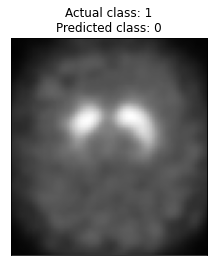

In [63]:
# Displaying the mis classifications

ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

In [65]:
!pip install lime

     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=17fdb1cebe07bbfee832a2255c3dcb53e1a79efefa90074790c6d5f548c30d2a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [76]:

#Import LIME

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# create lime ImageExplainer
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[10].astype(np.uint8)

In [77]:
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

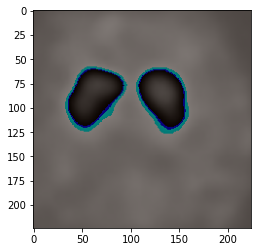

In [78]:
#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)

"""
def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        Init function.
        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation
        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
"""
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

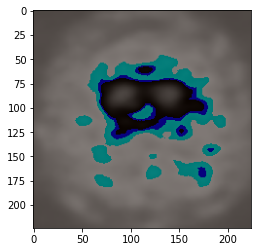

In [73]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, 
                                            num_features=10, 
                                            hide_rest=False)

"""
def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        Init function.
        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation
        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
"""
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

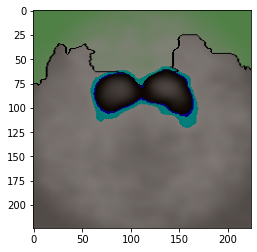

In [80]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[45].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

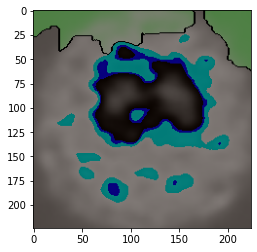

In [81]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[55].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

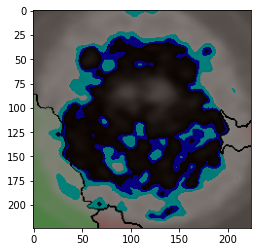

In [82]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[52].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

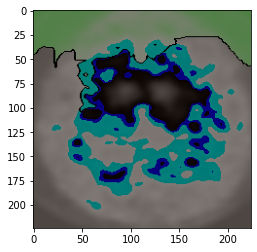

In [83]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[51].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

In [86]:
X_test_prep.shape

(65, 224, 224, 3)

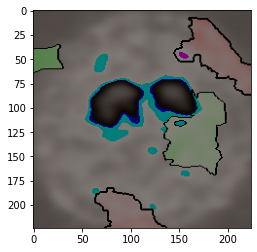

In [87]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[63].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

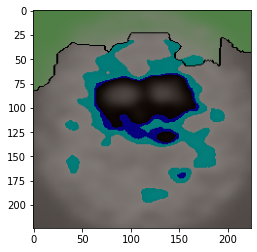

In [88]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[64].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

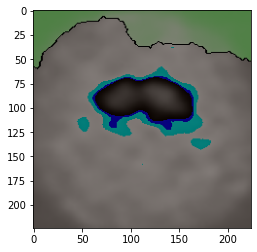

In [89]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[61].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

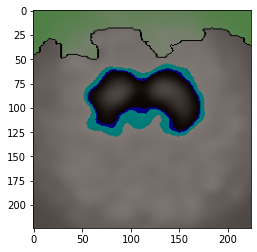

In [93]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[60].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

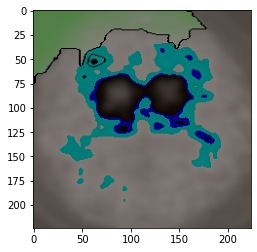

In [94]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[59].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

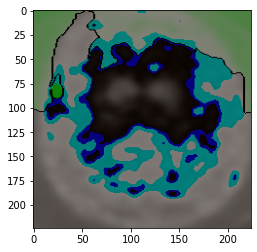

In [96]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[58].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

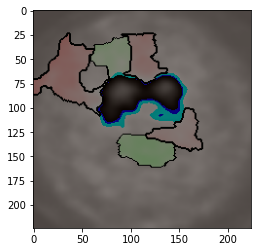

In [97]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[56].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

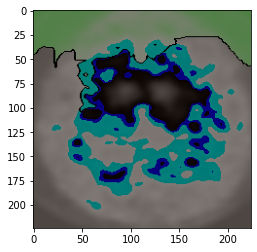

In [98]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[51].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

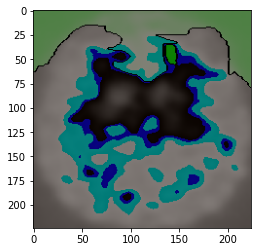

In [99]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[50].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))

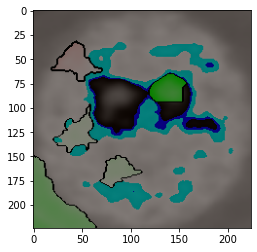

In [100]:
explainer = lime_image.LimeImageExplainer()

# Choosing the image from X_test_prep set
image = X_test_prep[40].astype(np.uint8)
# Apple LIME to the image

explanation = explainer.explain_instance(image, vgg16.predict, top_labels=2, hide_color=0, num_samples=1000)

#Arguments for get_image_and_mask() method defined below

temp, mask = explanation.get_image_and_mask(0, positive_only=False, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype(np.uint8))